In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/kaggle

/content/drive/MyDrive/kaggle


In [3]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras
from keras.models import Sequential
from tensorflow.keras import regularizers
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [4]:
all_path = []
labels = []
for item in glob.glob('OralCancer/*/*'):
  all_path.append(item)
  labels.append(item.split('/')[1])

In [5]:
images = []
for path in all_path:
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224,224))
  img = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  # img = img / 255.0
  images.append(img)
images = np.array(images)

In [6]:
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels)
# print(labels)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.1,shuffle  = True,random_state=0)

In [8]:
x_train.shape

(117, 224, 224, 3)

In [9]:
train_datagen = ImageDataGenerator(
    # rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [10]:
train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size = 25)
# validation_generator = validation_datagen.flow_from_directory(
#     val_set,
#     target_size = (224,224),
#     batch_size = 8,
#     shuffle=True,
#     class_mode = 'binary')
# test_generator = test_datagen.flow_from_directory(
#     test_set,
#     target_size = (224,224),
#     batch_size = 8,
#     class_mode = 'binary')

In [11]:
new_xtrain = []
new_ytrain = []

for i in range(90):
    x_batch, y_batch = train_generator.next()
    new_xtrain.append(x_batch)
    new_ytrain.append(y_batch)

new_xtrain = np.concatenate(new_xtrain, axis=0)
new_ytrain = np.concatenate(new_ytrain, axis=0)

In [12]:
print(f"shape of xtrain: {new_xtrain.shape}")

print(f"shape of ytrain: {new_ytrain.shape}")

shape of xtrain: (2106, 224, 224, 3)
shape of ytrain: (2106, 2)


In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image

In [14]:
base_for_model = tf.keras.applications.VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)

In [15]:
for layer in base_for_model.layers:
    layer.trainable = False

In [28]:
model = Sequential()
model.add(base_for_model)
# model.add(GaussianNoise(0.25)) #to prevent overfitting
model.add(Dropout(0.6))
model.add(GaussianNoise(0.35))     # copy of above line
model.add(GlobalAveragePooling2D()) #to converge and reduce the parameters
model.add(Dense(128, activation = 'relu')) #hidden layer (relu activation function is suggested for images)
model.add(Dropout(0.5))
model.add(BatchNormalization()) #to prevent overfitting
model.add(Dense(2, activation='sigmoid')) #output layer

In [29]:
adam= tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam,loss= 'binary_crossentropy', metrics=['accuracy','Recall'])

In [30]:
mp= tf.keras.callbacks.ModelCheckpoint(filepath='mymodel.hdf5',
                               verbose=1, save_best_only=True)
es= tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.05, patience=3)
callback=[es,mp]

In [31]:
##### validation data
import random
random.seed(0)
x_train, x_validation, y_train, y_validation = train_test_split(new_xtrain, new_ytrain, test_size=0.3,shuffle  = True,random_state=0)

In [32]:
x_train.shape

(1474, 224, 224, 3)

In [33]:
history = model.fit(
    new_xtrain,
    new_ytrain,
    batch_size=64, #steps_per_epoch= training_images/batch_size= 4946/8<=618
    epochs = 15, #own choice
    validation_data = (x_validation,y_validation),
    callbacks=callback
)

Epoch 1/15
33/33 [==============================] - ETA: 0s - loss: 0.6277 - accuracy: 0.6857 - recall: 0.6557
Epoch 1: val_loss improved from inf to 0.53041, saving model to mymodel.hdf5
33/33 [==============================] - 19s 510ms/step - loss: 0.6277 - accuracy: 0.6857 - recall: 0.6557 - val_loss: 0.5304 - val_accuracy: 0.7753 - val_recall: 0.6108
Epoch 2/15
33/33 [==============================] - ETA: 0s - loss: 0.4152 - accuracy: 0.8276 - recall: 0.8248
Epoch 2: val_loss improved from 0.53041 to 0.47085, saving model to mymodel.hdf5
33/33 [==============================] - 18s 561ms/step - loss: 0.4152 - accuracy: 0.8276 - recall: 0.8248 - val_loss: 0.4708 - val_accuracy: 0.7041 - val_recall: 0.7025
Epoch 3/15
33/33 [==============================] - ETA: 0s - loss: 0.3337 - accuracy: 0.8775 - recall: 0.8732
Epoch 3: val_loss improved from 0.47085 to 0.43391, saving model to mymodel.hdf5
33/33 [==============================] - 15s 456ms/step - loss: 0.3337 - accuracy: 0.877

In [34]:
print(history.history.keys())
import matplotlib.pyplot as plt
acc=(history.history['accuracy'])
loss=(history.history['loss'])
rec=(history.history['recall'])
val_acc=(history.history['val_accuracy'])
val_loss=(history.history['val_loss'])
val_rec=(history.history['val_recall'])

dict_keys(['loss', 'accuracy', 'recall', 'val_loss', 'val_accuracy', 'val_recall'])


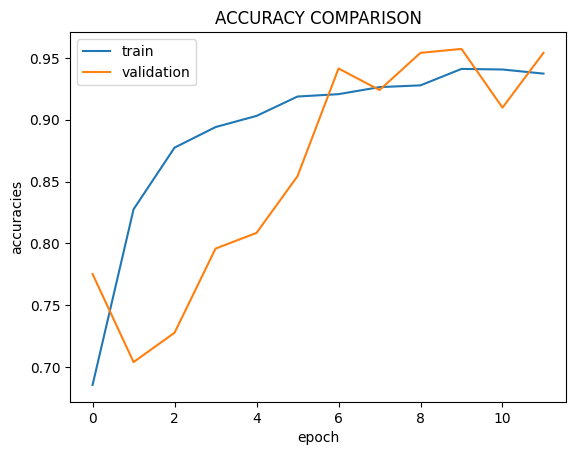

In [35]:
plt.plot(acc)
plt.plot(val_acc)
plt.title('ACCURACY COMPARISON')
plt.xlabel('epoch')
plt.ylabel('accuracies')
plt.title('ACCURACY COMPARISON')
plt.legend(['train','validation'])

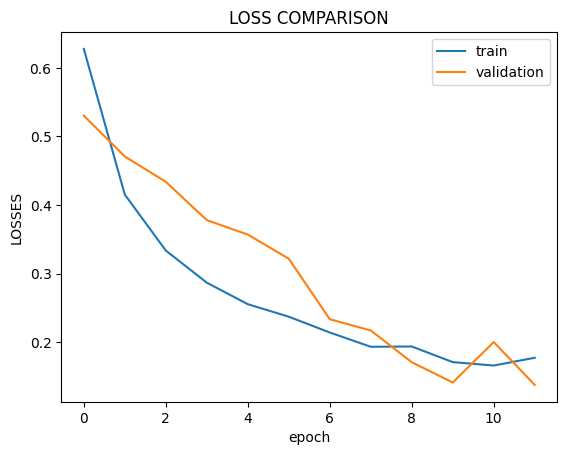

In [36]:
plt.plot(loss)
plt.plot(val_loss)
plt.title('LOSS COMPARISON')
plt.xlabel('epoch')
plt.ylabel('LOSSES')
plt.title('LOSS COMPARISON')
plt.legend(['train','validation'])

In [55]:
#######################################################################################
#######################################################################################
#######################################################################################
#######################################################################################